In [11]:
%matplotlib inline
import os, json
# os.environ["CUDA_VISIBLE_DEVICES"]=""
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycococreatortools import pycococreatortools
from icevision import models, parsers, show_records, tfms, Dataset, Metric, COCOMetric, COCOMetricType
from icevision.imports import *
from icevision.utils import *
from icevision.data import *
from icevision.metrics.metric import *
from sklearn.metrics import confusion_matrix, f1_score
import skimage.io as skio
from ceruleanml.coco_stats import all_sample_stat_lists
from ceruleanml.coco_load_fastai import record_collection_to_record_ids, get_image_path, record_to_mask
from ceruleanml import preprocess
from ceruleanml import data
from fastai.callback.tracker import SaveModelCallback
from fastai.callback.tensorboard import TensorBoardCallback
from icevision.metrics import SimpleConfusionMatrix # make sure you have the rbavery fork of icevision installed
import torch
torch.cuda.empty_cache()

In [3]:
bs_d ={512:14, 256:28, 224:28, 128:50, 64:128} # Batch Size for each image size
lr_d = {512:3e-4, 256:1e-3, 224:3e-3, 128:3e-3, 64:1e-2} # Learning Rate for each image size
# the timeings below are safe on a T4. spikes in gpu mem for smaller im sizes 
# with large batch size cause OOM. 34 bs for 224 for example
mins_d = {512:5.01, 256:3.1, 224:3.1, 128:2.5, 64:1.6} 
run_list = [[224, 180]]*1 # List of tuples, where the tuples are [px size, training time in minutes]
# run_list = [[64, 1]]*1+[[128, 1]]*1+[[224, 1]]*1 +[[512, 1]]*1
init_size = run_list[0][0]
fp16 = False
n = "all"
arch = 34
negative_sample_count = 0
negative_sample_count_val = 0
area_thresh = 0
remove_list=["ambiguous", "natural_seep"]
class_names_to_keep=[
            "background",
            "infra_slick",
            "recent_vessel",
        ]
remap_dict = {  # only remaps coincident and old to recent
            3: 4,
            5: 4,
        }

# since we remove ambiguous and natural seep and remap all vessels to 1 and include background
num_classes = 3 

model_type = models.torchvision.mask_rcnn
backbone = model_type.backbones.resnet34_fpn
# causes kernel death without any CUDA out of memory error or traceback aftr training for a while
# model_type = models.mmdet.mask_rcnn
# backbone = model_type.backbones.mask_rcnn_swin_t_p4_w7_fpn_1x_coco

### Important! 

Make sure you have copied the dataset to the local SSD of the VM at /root. Loading the data from a GCP bucket takes a full 2 minutes compared to 17 seconds when data is on the SSD.

You can run the following for example to copy a dataset from the bucket to the vm quickly.

```
mkdir tile-cerulean-v2-partial-with-context
gsutil -m rsync -ravzp gs://ceruleanml/tile-cerulean-v2-partial-with-context tile-cerulean-v2-partial-with-context
```

In [4]:
mount_path = "/root"

In [5]:
### Parsing COCO Dataset with Icevision

train_set = "train-with-context-512"
tiled_images_folder_train = "tiled_images"
json_name_train = "instances_TiledCeruleanDatasetV2.json"

coco_json_path_train = f"{mount_path}/partitions/{train_set}/{json_name_train}"
tiled_images_folder_train = f"{mount_path}/partitions/{train_set}/{tiled_images_folder_train}"
val_set = "val-with-context-512"
tiled_images_folder_val= "tiled_images"
json_name_val = "instances_TiledCeruleanDatasetV2.json"
coco_json_path_val= f"{mount_path}/partitions/{val_set}/{json_name_val}"
tiled_images_folder_val = f"{mount_path}/partitions/{val_set}/{tiled_images_folder_val}"

# f"{mount_path}/partitions/val/instances_tiled_cerulean_train_v2.json"

## looking at area distribution to find area threshold

# df = preprocess.get_area_df(coco_json_path_train, tiled_images_folder_train)
# df

In [6]:
record_collection_with_negative_small_filtered_train = preprocess.load_set_record_collection(
    coco_json_path_train, tiled_images_folder_train, area_thresh, negative_sample_count, preprocess=False, class_names_to_keep=class_names_to_keep,
    remap_dict=remap_dict, remove_list=remove_list
)
record_ids_train = record_collection_to_record_ids(record_collection_with_negative_small_filtered_train)

record_collection_with_negative_small_filtered_val = preprocess.load_set_record_collection(
    coco_json_path_val, tiled_images_folder_val, area_thresh, negative_sample_count_val, preprocess=False, class_names_to_keep=class_names_to_keep,
    remap_dict=remap_dict, remove_list=remove_list
)
record_ids_val = record_collection_to_record_ids(record_collection_with_negative_small_filtered_val)

assert len(set(record_ids_train)) + len(set(record_ids_val)) == len(record_ids_train) + len(record_ids_val)

train_val_record_ids = record_ids_train + record_ids_val
combined_record_collection = record_collection_with_negative_small_filtered_train + record_collection_with_negative_small_filtered_val

Annotations before filtering classes: 3863
Images before filtering classes: 58332
Annotations after filtering classes: 3173
Images after filtering classes: 57722


  0%|          | 0/3173 [00:00<?, ?it/s]

Annotations before filtering classes: 352
Images before filtering classes: 5883
Annotations after filtering classes: 308
Images after filtering classes: 5849


  0%|          | 0/308 [00:00<?, ?it/s]

In [7]:
class_map = {v: k for k, v in enumerate(record_collection_with_negative_small_filtered_train[0].detection.class_map.get_classes())}
class_ints = list(range(1, len(list(class_map.keys())[:-1]) + 1))

necessary step is to clone rbavery icevision and isntall it into environment

This func is adapted in the icevision fork to only show the first channel of the three channel dataset in `draw_sample`

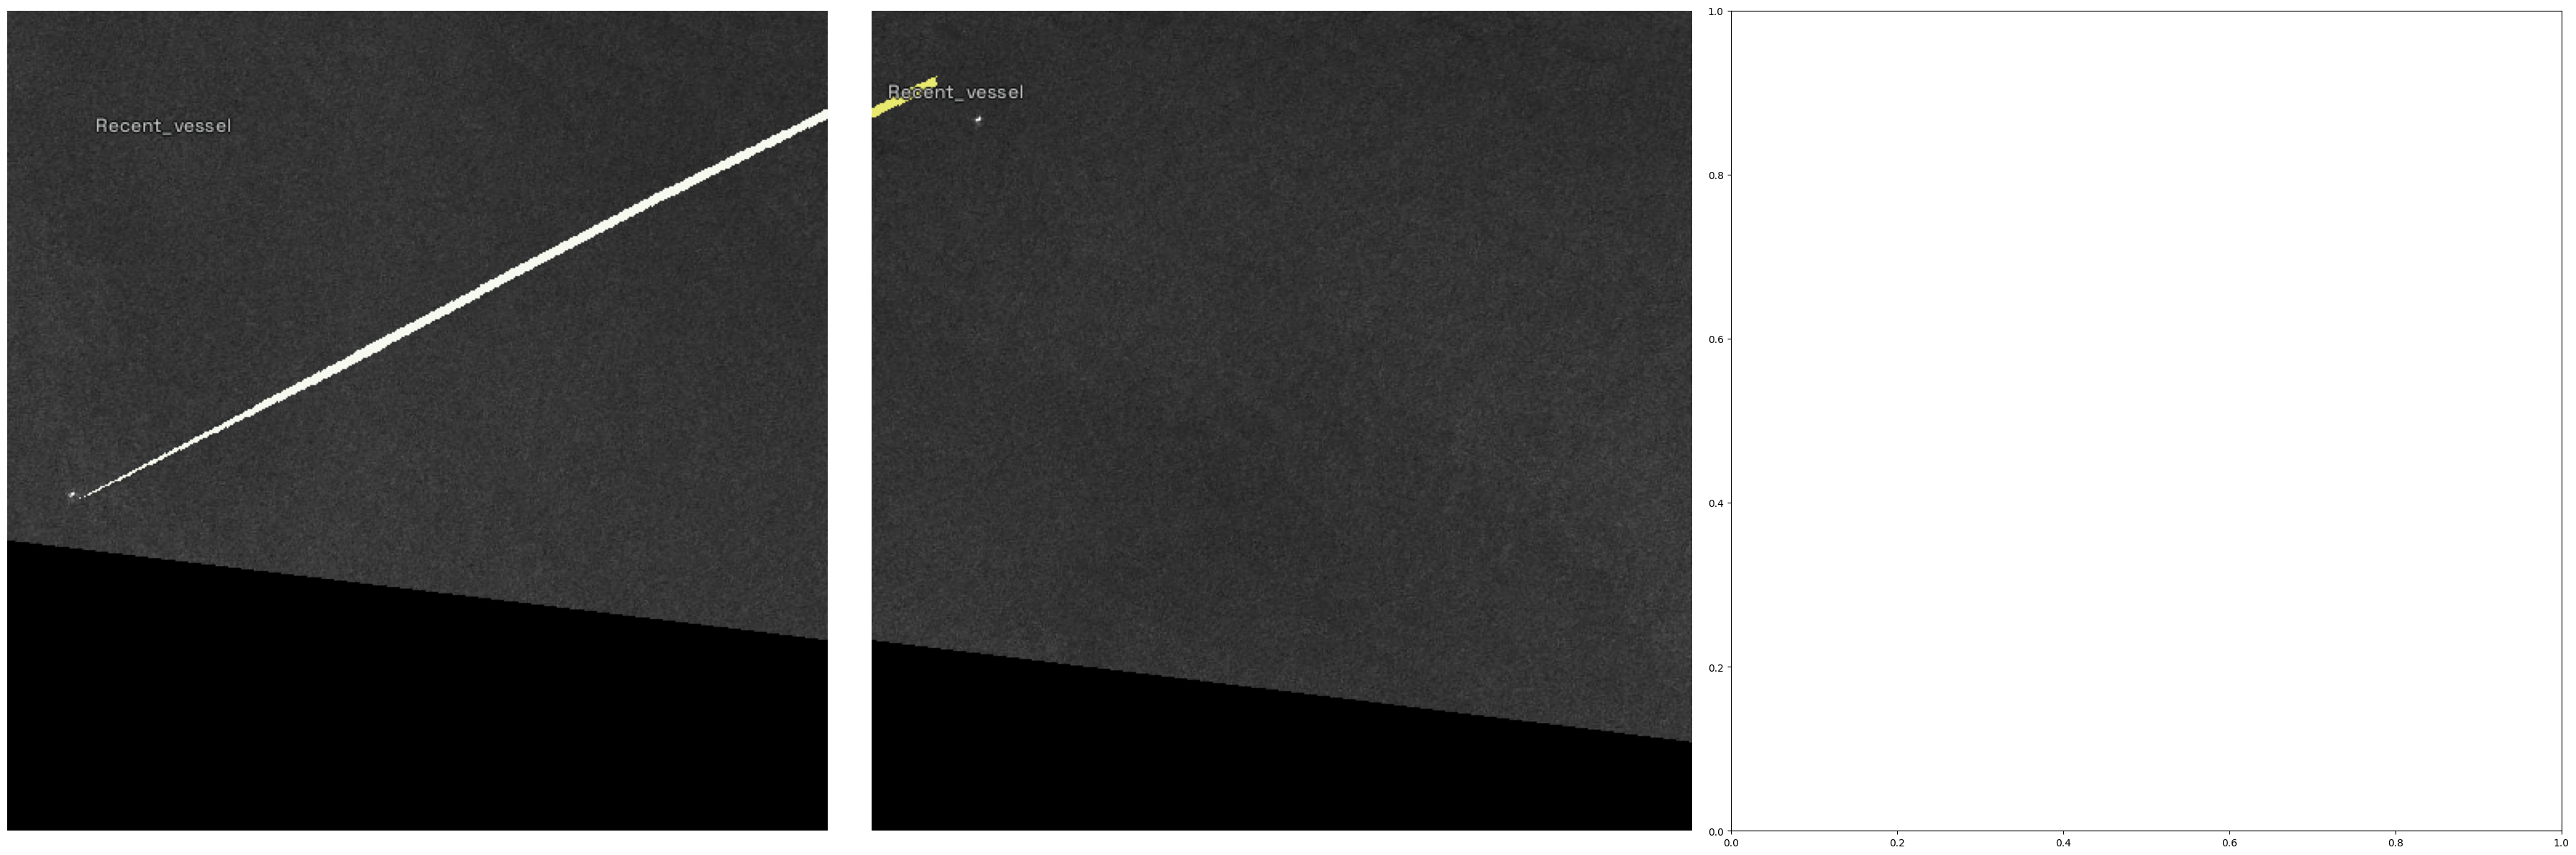

In [8]:
# %matplotlib inline
show_records(record_collection_with_negative_small_filtered_train[0:2], ncols=3, class_map=class_map, display_mask=True, display_bbox=False)

In [9]:
valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])
train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=init_size)])

sourced from: https://airctic.com/0.8.1/getting_started_instance_segmentation/

In [12]:
train_ds = Dataset(record_collection_with_negative_small_filtered_train, train_tfms)
valid_ds = Dataset(record_collection_with_negative_small_filtered_val, valid_tfms)
train_dl = model_type.train_dl(train_ds, batch_size=32, num_workers=6, shuffle=True) # adjust num_workers for your processor count
valid_dl = model_type.valid_dl(valid_ds, batch_size=32, num_workers=6, shuffle=False)
infer_dl = model_type.infer_dl(valid_ds, batch_size=32, shuffle=False)
metrics = [SimpleConfusionMatrix(print_summary=True)]

model = model_type.model(backbone=backbone(pretrained=True), num_classes=num_classes)
learner = model_type.fastai.learner(dls=[train_dl, valid_dl], model=model, cbs=SaveModelCallback(min_delta=.01), metrics=metrics) # cbs=SaveModelCallback

running_total_epochs = {}

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

1 train epoch is about 4 minutes. 1 validation epoch of 76 samples is also about a minute.

# No Progressive Resize

In [13]:
#learner.fine_tune(35, 3e-3) # 3e-3 is hand selected lr
# learn.fine_tune(2, lr.valley) #, freeze_epochs=2)

## Progressive Resizing

We save the model first if using savemodel callback or else there is an error saying model.pth does not exist

In [14]:
learner.save("model")

Path('models/model.pth')

In [ ]:
from icevision.models.utils import get_dataloaders
from icevision.engines.fastai import convert_dataloaders_to_fastai


for size, total_train_time in run_list:
    epochs = max(int(total_train_time/mins_d[size]), 1)
    bs = bs_d[size]
    lr = lr_d[size]
    valid_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size)])
    train_tfms = tfms.A.Adapter([*tfms.A.resize_and_pad(size=size)])
    ds, dls = get_dataloaders(model_type, [record_collection_with_negative_small_filtered_train, record_collection_with_negative_small_filtered_val], [train_tfms, valid_tfms], batch_size=bs, num_workers=8)
    fastai_dls = convert_dataloaders_to_fastai(dls=dls)
    learner.dls = fastai_dls
    print(f"Training time is: {total_train_time} minutes")
    print("starting from running total", running_total_epochs)
    print("image size", size)
    print("batch size", bs)
    print("arch", arch)
    print("lr", lr)
    print("n chips", n)
    print("context")
    print("epochs", epochs)
    print("num_classes", num_classes)

    learner.fine_tune(epochs, lr, freeze_epochs=0) # cbs=cbs

    running_total_epochs[size] = sum(filter(None,[running_total_epochs.get(size),epochs]))

Training time is: 180 minutes
starting from running total {}
image size 224
batch size 28
arch 34
lr 0.003
n chips all
context
epochs 58
num_classes 3


epoch,train_loss,valid_loss,SimpleConfusionMatrix,time
0,0.782392,0.615853,"[{'Infra P': 0.0, 'Vessel P': 0.852}, {'Infra Recall': 0.0, 'Vessel Recall': 0.25}, {'Infra f1': 0.0, 'Vessel f1': 0.387}]",02:22


/root/work/.ice-env/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/root/work/.ice-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/root/work/.ice-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


[[  0   0   0]
 [116   0   8]
 [138   0  46]]
Better model found at epoch 0 with valid_loss value: 0.6158530712127686.


# Instance Evaluation

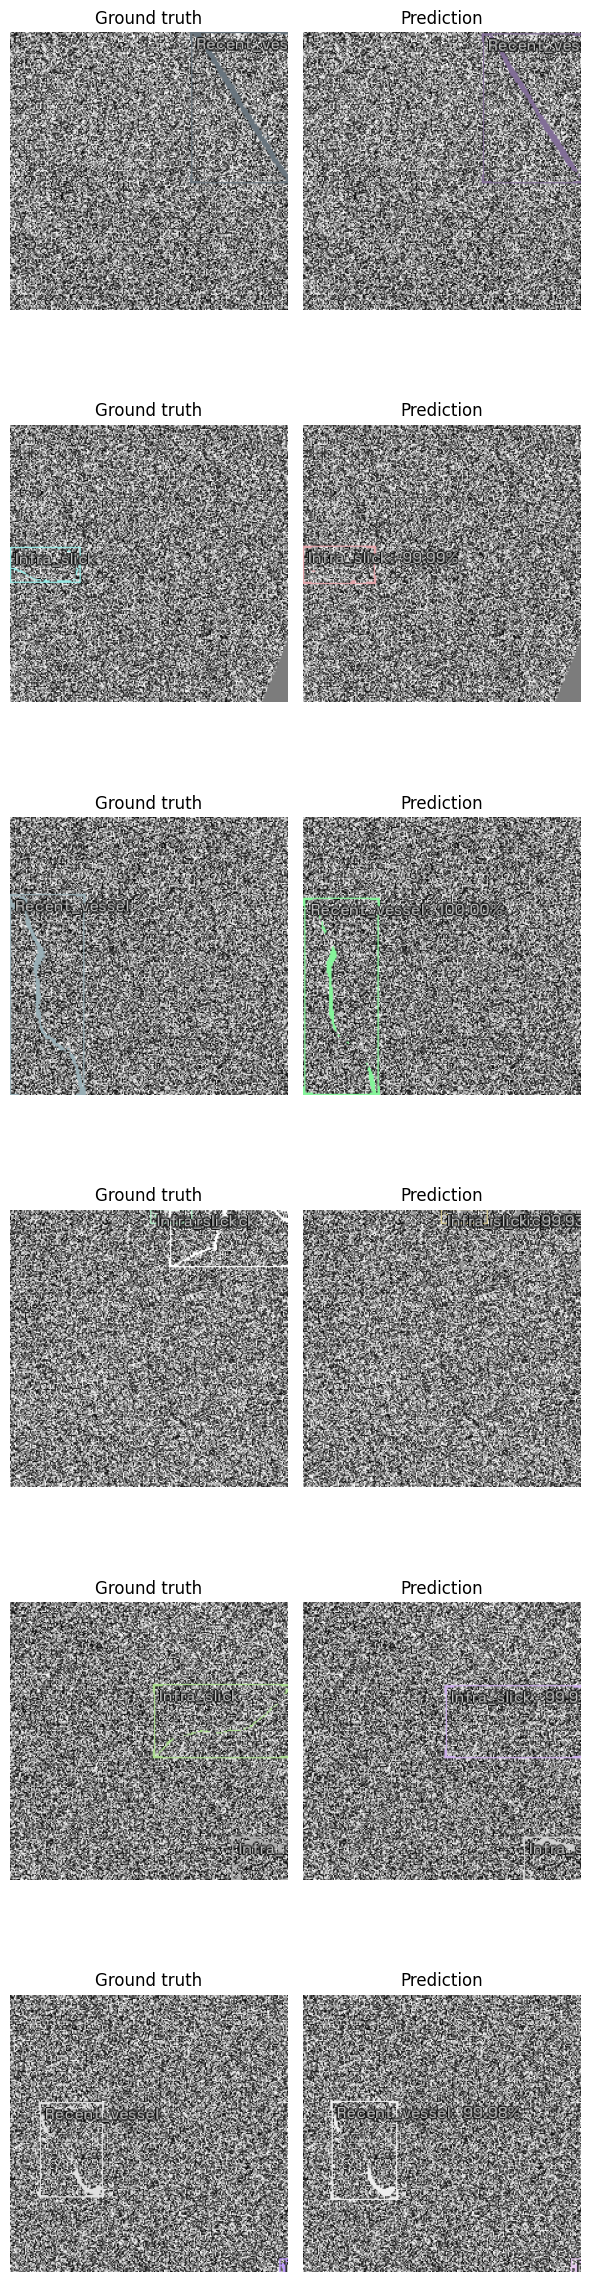

In [14]:
model_type.show_results(model, valid_ds, detection_threshold=.5)

savemodel callback bugs this

In [15]:
validation = learner.validate()

IndexError: Exception occured in `SaveModelCallback` when calling event `after_epoch`:
	list index out of range

# Exporting the model

In [16]:
from datetime import datetime
dateTimeObj = datetime.now()
timestampStr = dateTimeObj.strftime("%d_%b_%Y_%H_%M_%S")
experiment_dir =  Path(f'{mount_path}/experiments/cv2/'+timestampStr+'_icevision_maskrcnn/')
experiment_dir.mkdir(exist_ok=True)
print(experiment_dir)
learner.save(os.path.join(experiment_dir,"model"))

/root/experiments/cv2/20_Jul_2022_00_14_15_icevision_maskrcnn


In [1]:
from ceruleanml.inference import save_icevision_model_state_dict_and_tracing, load_tracing_model, test_tracing_model_one_batch, logits_to_classes
save_template = "model.pt"
state_dict_pth, tracing_model_cpu_pth  = save_icevision_model_state_dict_and_tracing(learner, save_template, experiment_dir)

# Tips

* `nvidia-smi -lms` reports at millisecond frequency and can reveal big gpu spikes
* a TODO is to debug the COCOMetric, it should not be -1 given that we are now acheiving detections that intersect with groundtruth. It's documented in icevision issues that the COCOMetric doesn't work for torchvision models because of a bounding box coordinate conversion error. They say it works for mmdet but mmdet does not support negative samples and was erroring saying there were negative samples even when none were included and no data transformations were done.
* for the icevision trainer, class mismatch from preprocess remap causes long pauses then training failure. restarting kernel causes . reboot causes driver removal and need to redeploy

# TODO

* save model, run inference
* remove classes from json and resave
* dicemulti metric for icevision